In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Fetch PES Points 

In [2]:
path = "../TaskC/pes.tab"

r = []
E_HF = []
E_CCSDT = []

with open(path, "r") as f:
    for line in f:
        try:
            splits = list(map(float, line.split()))

            r.append(splits[0])
            E_HF.append(splits[1])
            E_CCSDT.append(splits[2])
        except:
            pass
        
#r = np.asarray(r)
E_HF = np.asarray(E_HF)
E_CCSDT = np.asarray(E_CCSDT)

# PChip Interpolation 

In [8]:
from scipy.interpolate import PchipInterpolator as PChip

interpolator_HF = PChip(r, E_HF)
interpolator_CCSDT = PChip(r, E_CCSDT)

# Display PES 

## Data 

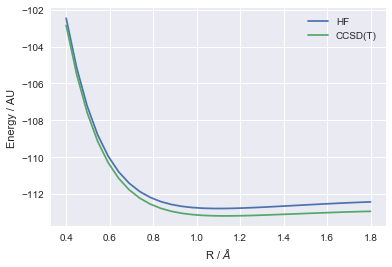

In [10]:
plt.plot(r, E_HF, label="HF")
plt.plot(r, E_CCSDT, label="CCSD(T)")

plt.xlabel("R / $\AA$")
plt.ylabel("Energy / AU")

plt.legend()

## Interpolated 

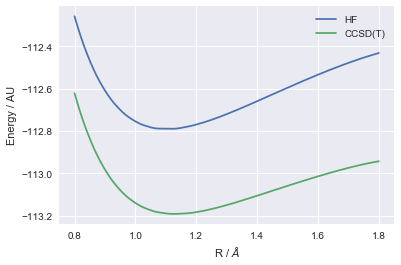

In [13]:
t = np.linspace(0.8, 1.8, 500)

plt.plot(t, interpolator_HF(t), label="HF")
plt.plot(t, interpolator_CCSDT(t), label="CCSD(T)")

plt.xlabel("R / $\AA$")
plt.ylabel("Energy / AU")

plt.legend()

# Make Hamiltonian 

In [34]:
# dimensio of hamiltonian
N = 1000

In [35]:
from scipy.constants import physical_constants

# TODO units should be in AU!!
u = physical_constants["atomic mass constant"][0]

m_C = 12 * u
m_O = 16 * u

## Kinetic Term

In [36]:
from scipy.constants import hbar
from scipy.sparse import diags

mu = m_C * m_O / (m_C + m_O)

P = hbar**2 / (2 * mu) * (
    diags(2 * np.ones(N)) + \
    diags(-1 * np.ones(N-1), -1) + \
    diags(-1 * np.ones(N-1), +1)
)
    

## Potential Term 

In [37]:
r = np.linspace(0.8, 1.8, N)

U_HF = diags(interpolator_HF(r))
U_CCSDT = diags(interpolator_CCSDT(r))

## H = P + U 

In [38]:
H_HF = P + U_HF
H_CCSDT = P + U_CCSDT

#  Solve Finite Differences Equations


Eigenvalueproblem: $\hat{H} |\psi\rangle = E |\psi\rangle$

Finite differences: $\psi = \{\psi_1, \psi_2, \ldots, \psi_n\}$

In [39]:
# numer of eigen values 
n = 30

## HF 

In [40]:
from scipy.sparse.linalg import eigsh

E, psi = eigsh(H_HF, n)

In [41]:
print(E)

[-112.78978309 -112.78978303 -112.78978226 -112.7897808  -112.78977872
 -112.78977601 -112.78977269 -112.78977263 -112.78976875 -112.78976419
 -112.78975902 -112.78975325 -112.78974739 -112.78974687 -112.78973989
 -112.78973232 -112.78972414 -112.78971538 -112.7897077  -112.78970602
 -112.78969608 -112.78968556 -112.78967445 -112.78966277 -112.78965398
 -112.78965051 -112.78963768 -112.78962428 -112.78961032 -112.78959579]


## CCSD(T) 

In [42]:
E, psi = eigsh(H_CCSDT, n)

In [43]:
print(E)

[-113.19237223 -113.19236953 -113.19236909 -113.19236295 -113.19235648
 -113.19235258 -113.19233848 -113.19233449 -113.19232074 -113.19230334
 -113.19229944 -113.19227464 -113.19226321 -113.19224644 -113.1922149
 -113.19221432 -113.1921801  -113.19215687 -113.19214212 -113.19210104
 -113.19209106 -113.19205694 -113.19201709 -113.19200989 -113.19195998
 -113.19193516 -113.19190726 -113.19185184 -113.19184549 -113.19179378]
